Part 3: Identify 10,000 Medicare patients who were involved in anomalous activities.

In [159]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
import numpy as np
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas_profiling
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
import imblearn
from sklearn.feature_selection import RFE
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
pat_hist = pd.read_csv("D:/Analytix labs/Assignments & Case Studies/Data Science with Python (Foundation) Case study/9. End to End Foundation Case Study-1/Patient_history_samp.csv", sep = ",")
rev_pat_hist = pd.read_csv("D:/Analytix labs/Assignments & Case Studies/Data Science with Python (Foundation) Case study/9. End to End Foundation Case Study-1/Review_patient_history_samp.csv", sep = ",")
rev_tran = pd.read_csv("D:/Analytix labs/Assignments & Case Studies/Data Science with Python (Foundation) Case study/9. End to End Foundation Case Study-1/Rreview_transaction_coo.csv", sep = ",")
tran = pd.read_csv("D:/Analytix labs/Assignments & Case Studies/Data Science with Python (Foundation) Case study/9. End to End Foundation Case Study-1/Transaction_coo.csv", sep = ",")

In [3]:
pat_hist.head()

,id,age,gender,income
0,306535165,65-74,F,24000-31999
1,742231134,65-74,F,48000+
2,928807201,75-84,M,24000-31999
3,83686538,<65,F,32000-47999
4,755607449,65-74,F,48000+


In [4]:
rev_pat_hist.head()

,id,age,gender,income
0,381693273,65-74,F,24000-31999
1,444060924,65-74,M,24000-31999
2,3641691,65-74,F,24000-31999
3,672653795,65-74,M,48000+
4,144916176,<65,F,48000+


In [5]:
pat_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
id        500000 non-null int64
age       497470 non-null object
gender    500000 non-null object
income    497469 non-null object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [6]:
rev_pat_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id        5000 non-null int64
age       4974 non-null object
gender    5000 non-null object
income    4974 non-null object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


Converting categorical variables to numerical variables

In [7]:
#Age
def age_num(pat):
    if pat['age'] == '65-74':
        return 2
    elif pat['age'] == '75-84':
        return 3
    elif pat['age'] == '85+':
        return 4
    else:
        return 1

In [8]:
#Gender
def gender_num(pat):
    if pat['gender'] == 'M':
        return 1
    else:
        return 0

In [9]:
#Income
def income_num(pat):
    if pat['income'] == '16000-23999':
        return 2
    elif pat['income'] == '24000-31999':
        return 3
    elif pat['income'] == '32000-47999':
        return 4
    elif pat['income'] == '48000+':
        return 5
    else:
        return 1

In [10]:
pat_hist['Age_grp'] = pat_hist.apply(age_num, axis = 1)
pat_hist['Gender_grp'] = pat_hist.apply(gender_num, axis = 1)
pat_hist['Inc_grp'] = pat_hist.apply(income_num, axis = 1)
rev_pat_hist['Age_grp'] = rev_pat_hist.apply(age_num, axis = 1)
rev_pat_hist['Gender_grp'] = rev_pat_hist.apply(gender_num, axis = 1)
rev_pat_hist['Inc_grp'] = rev_pat_hist.apply(income_num, axis = 1)

In [11]:
pat_hist.drop(['age','gender','income'], axis = 1, inplace=True)
rev_pat_hist.drop(['age','gender','income'], axis = 1, inplace=True)

In [12]:
pat_hist.head()

,id,Age_grp,Gender_grp,Inc_grp
0,306535165,2,0,3
1,742231134,2,0,5
2,928807201,3,1,3
3,83686538,1,0,4
4,755607449,2,0,5


In [13]:
rev_pat_hist.head()

,id,Age_grp,Gender_grp,Inc_grp
0,381693273,2,0,3
1,444060924,2,1,3
2,3641691,2,0,3
3,672653795,2,1,5
4,144916176,1,0,5


In [14]:
rev_tran.head()

,id,global_proc_id,count
0,65822,109,1
1,65822,125,1
2,119695,70,1
3,119695,124,1
4,119695,125,1


creating dummies and full unmarked dataset

In [15]:
global_proc_dummy = pd.get_dummies(tran['global_proc_id'], prefix = 'proc')
tran_dum = pd.concat([tran,global_proc_dummy], axis = 1)
tran_dum.drop('global_proc_id', axis = 1, inplace = True)
tran_dum.head()

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
0,159125,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,191852,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,321083,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,383037,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,467729,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
col_list = list(tran_dum.columns)

In [31]:
tran_grp = pd.DataFrame(tran_dum[col_list].groupby('id').agg({'count':'sum', 'proc_1' :'sum' ,
                                                                                                                         'proc_2' :'sum' ,'proc_3' :'sum' ,
'proc_4' :'sum' , 'proc_5' :'sum' , 'proc_6' :'sum' ,'proc_7' :'sum' , 'proc_8' :'sum' ,'proc_9' :'sum' , 'proc_10' :'sum' ,
'proc_11' :'sum' , 'proc_12' :'sum' , 'proc_13' :'sum' , 'proc_14' :'sum' , 'proc_15' :'sum' ,'proc_16' :'sum' , 'proc_17' :'sum' ,
'proc_18' :'sum' , 'proc_19' :'sum' ,  'proc_20' :'sum' , 'proc_21' :'sum' ,  'proc_22' :'sum' , 'proc_23' :'sum' ,
'proc_24' :'sum' ,'proc_25' :'sum' ,'proc_26' :'sum' ,   'proc_27' :'sum' , 'proc_28' :'sum' ,  'proc_29' :'sum' ,'proc_30' :'sum' ,
 'proc_31' :'sum','proc_32' :'sum' , 'proc_33' :'sum' , 'proc_34' :'sum' ,  'proc_35' :'sum' , 'proc_36' :'sum' ,
 'proc_37' :'sum' , 'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))
tran_grp.head()

,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
id,,,,,,,,,,,,,,,,,,,,,
7561,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7619,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10479,4,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13515,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15213,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
tran_grp = tran_grp.reset_index()
unmarked_data = tran_grp.merge(pat_hist,on = 'id', how = 'left')
unmarked_data

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130,Age_grp,Gender_grp,Inc_grp
0,7561,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,1.0,5.0
1,7619,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,0.0,5.0
2,10479,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,0.0,1.0
3,13515,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,1.0,1.0
4,15213,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504995,999987129,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.0,0.0,1.0
504996,999993165,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,1.0,1.0
504997,999994693,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.0,1.0,1.0
504998,999994769,3,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2.0,0.0,1.0


creating dummies and full reviewed dataset

In [19]:
global_proc_dummy1=pd.get_dummies(rev_tran['global_proc_id'], prefix='proc')
rev_tran_dum = pd.concat([rev_tran, global_proc_dummy1], axis=1)
rev_tran_dum.drop( 'global_proc_id', axis = 1, inplace = True )
rev_tran_dum.head()

,id,count,proc_1,proc_2,proc_3,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
0,65822,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65822,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,119695,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,119695,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,119695,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [20]:
col_list1 = list(rev_tran_dum.columns)

In [21]:
rev_tran_grp = pd.DataFrame(rev_tran_dum[col_list1].groupby(['id']).agg({'count':'sum',
                                                                                         'proc_1' :'sum' ,
                                                                                         'proc_2' :'sum' ,
                                                                                         'proc_3' :'sum' ,
                                                                                         'proc_5' :'sum' ,
                                                                                         'proc_6' :'sum' ,
                                                                                         'proc_7' :'sum' ,
                                                                                         'proc_8' :'sum' ,
                                                                                         'proc_9' :'sum' ,
                                                                                         'proc_10' :'sum' ,
                                                                                         'proc_11' :'sum' ,
                                                                                         'proc_12' :'sum' ,
                                                                                         'proc_13' :'sum' ,
                                                                                         'proc_14' :'sum' ,
                                                                                         'proc_15' :'sum' ,
                                                                                         'proc_16' :'sum' ,
                                                                                         'proc_17' :'sum' ,
                                                                                         'proc_18' :'sum' ,
                                                                                         'proc_19' :'sum' ,
                                                                                         'proc_20' :'sum' ,
                                                                                         'proc_21' :'sum' ,
                                                                                         'proc_22' :'sum' ,
                                                                                         'proc_23' :'sum' ,
                                                                                         'proc_24' :'sum' ,
                                                                                         'proc_25' :'sum' ,
                                                                                         'proc_26' :'sum' ,
                                                                                         'proc_27' :'sum' ,
                                                                                         'proc_28' :'sum' ,
                                                                                         'proc_29' :'sum' ,
                                                                                         'proc_30' :'sum' ,
                                                                                         'proc_31' :'sum' ,
                                                                                         'proc_32' :'sum' ,
                                                                                         'proc_33' :'sum' ,
                                                                                         'proc_34' :'sum' ,
                                                                                         'proc_35' :'sum' ,
                                                                                         'proc_36' :'sum' ,
                                                                                         'proc_37' :'sum' ,
                                                                                         'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))

In [22]:
rev_tran_grp.head()

,count,proc_1,proc_2,proc_3,proc_5,proc_6,proc_7,proc_8,proc_9,proc_10,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
id,,,,,,,,,,,,,,,,,,,,,
65822,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
119695,3,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
131488,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
360915,3,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
389225,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
rev_tran_grp = rev_tran_grp.reset_index()

In [24]:
# Reviewed dataset do not proc 4 - hence creating a dummy column with all zeros
rev_tran_grp['proc_4'] = 0

In [25]:
rev_tran_grp

,id,count,proc_1,proc_2,proc_3,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130,proc_4
0,65822,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,119695,3,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,131488,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,360915,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,389225,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,998845469,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,999347184,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,999454987,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,999460247,3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [26]:
reviewed_data = rev_tran_grp.merge(rev_pat_hist,on = 'id', how = 'left')
reviewed_data

,id,count,proc_1,proc_2,proc_3,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130,proc_4,Age_grp,Gender_grp,Inc_grp
0,65822,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,4,0,4
1,119695,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,4
2,131488,2,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,2,0,2
3,360915,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2
4,389225,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,998845469,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2
4996,999347184,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
4997,999454987,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,2
4998,999460247,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2


In [33]:
reviewed_data['flag'] = 1
unmarked_data['flag'] = 0

In [35]:
list1 = (unmarked_data.filter(like='proc').columns)
unmarked_data[list1] = unmarked_data[list1].astype('int64')
reviewed_data[list1] = unmarked_data[list1].astype('int64')

In [36]:
unmarked_data.dropna(axis=0, how='any', inplace = True)

In [38]:
unmarked_data[['Inc_grp', 'Age_grp', 'Gender_grp']] = unmarked_data[['Inc_grp', 'Age_grp', 'Gender_grp']].astype('int64')

In [39]:
unmarked_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 504999
Columns: 136 entries, id to flag
dtypes: int64(136)
memory usage: 522.6 MB


In [40]:
reviewed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 136 entries, id to flag
dtypes: int64(136)
memory usage: 5.2 MB


Association analysis - Using SMOTE to deal with imbalanced data and using random forest to create final model

In [62]:
sample_data = unmarked_data.sample(frac=0.1)

In [63]:
frames = [sample_data, reviewed_data]
train_df = pd.concat(frames)

In [64]:
cols = train_df.columns.difference( ['flag', 'id'] )

In [66]:
df_train = train_df[cols ]
df_test = unmarked_data[cols ]

In [68]:
train_X, test_X, train_y, test_y = train_test_split( train_df[cols ],
                                                  train_df['flag'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

In [70]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123, ratio = 0.5)
x_train_res, y_train_res = sm.fit_sample(train_X,  train_y)

In [74]:
df_test  = unmarked_data.copy()

In [125]:
clf = RandomForestClassifier(n_estimators=20 )
clf.fit(x_train_res, y_train_res)

# Make predictions for train and test dataset
predictions_train = clf.predict(x_train_res)
probs_train = clf.predict_proba(x_train_res)
predictions = clf.predict(df_test[cols])
probs = clf.predict_proba(df_test[cols])
display(predictions)

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [126]:
score = clf.score(x_train_res, y_train_res)
print("Accuracy: ", score)

Accuracy:  0.9557140238924341


Text(0.5, 12.5, 'Predicted label')

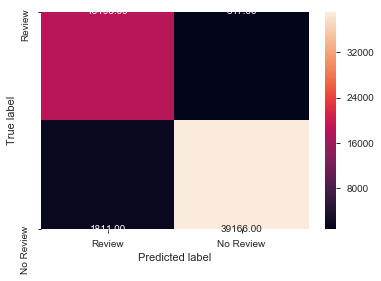

In [127]:
tree_cm = metrics.confusion_matrix( predictions_train,
                                 y_train_res, [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Review", "No Review"] , yticklabels = ["Review", "No Review"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [128]:
#Predicting the test cases
predictions_train_df = pd.DataFrame( { 'actual':  y_train_res,
                            'predicted': predictions_train } )

In [129]:
probs_train_df = pd.DataFrame(probs_train)
train_pred = pd.concat( [predictions_train_df, probs_train_df], axis = 1 )
train_pred.columns = ['actual', 'predicted', 'Review_0', 'Review_1']
train_pred.head(10)

,actual,predicted,Review_0,Review_1
0,0,0,0.950000,0.050000
1,0,0,0.650000,0.350000
2,1,0,0.500000,0.500000
3,0,0,0.950000,0.050000
4,0,0,1.000000,0.000000
5,1,1,0.200000,0.800000
6,0,0,0.900000,0.100000
7,0,0,0.850000,0.150000
8,0,0,0.900000,0.100000
9,1,1,0.365833,0.634167


In [130]:
score = clf.score(df_test[cols], df_test["flag"])
print("Accuracy: ", score)

Accuracy:  0.915738


In [123]:
df_test["prob_true"] = probs[:, 1]

In [139]:
df_anomalous= df_test[df_test["prob_true"] > 0.75 ]
df_anomalous["prob_true"].count()

11441

In [140]:
df_anomalous.head()

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,proc_126,proc_127,proc_128,proc_129,proc_130,Age_grp,Gender_grp,Inc_grp,flag,prob_true
130,262034,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,3,0,0.77931
143,283176,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,3,0,0.77000
185,355410,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,5,0,0.92000
249,486104,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,2,0,0.84000
257,504980,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,4,0,0.89000


There are 11441 patients who were involved in anomalous activities. This is close to our objective of finding 10000 patient.

Cluster analysis and using RFE to idnetify important features

In [162]:
indices = np.argsort(clf.feature_importances_)[::-1]
rfc = RandomForestClassifier()

# create the RFE model and select 20 attributes
rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(x_train_res, y_train_res)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), cols)]
selected_features = [v for i, v in feature_map if i==True]

In [163]:
selected_features

['Age_grp',
 'Gender_grp',
 'Inc_grp',
 'count',
 'proc_1',
 'proc_124',
 'proc_13',
 'proc_14',
 'proc_17',
 'proc_19',
 'proc_2',
 'proc_20',
 'proc_22',
 'proc_25',
 'proc_26',
 'proc_27',
 'proc_28',
 'proc_3',
 'proc_34',
 'proc_99']

In [165]:
df_subdata = df_anomalous.drop('prob_true', axis =1)
frames = [df_subdata, reviewed_data]
medi_data = pd.concat(frames)
medi_data.head()

,Age_grp,Gender_grp,Inc_grp,count,flag,id,proc_1,proc_10,proc_100,proc_101,...,proc_90,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99
130,2,0,3,2,0,262034,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143,3,1,3,3,0,283176,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
185,1,0,5,2,0,355410,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,3,1,2,3,0,486104,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
257,2,1,4,2,0,504980,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
analysis_data = medi_data[selected_features]
analysis_data.head()

,Age_grp,Gender_grp,Inc_grp,count,proc_1,proc_124,proc_13,proc_14,proc_17,proc_19,proc_2,proc_20,proc_22,proc_25,proc_26,proc_27,proc_28,proc_3,proc_34,proc_99
130,2,0,3,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
143,3,1,3,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
185,1,0,5,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
249,3,1,2,3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
257,2,1,4,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [167]:
col_list = analysis_data.columns

In [168]:
#Standardizing data before PCA
sc=StandardScaler()
analysis_scaled=sc.fit_transform(analysis_data)

In [169]:
#PCA

var_ratio={}
for n in range(2,20):
    pc = PCA(n_components=n)
    analysis_pca=pc.fit(analysis_scaled)
    var_ratio[n]=sum(analysis_pca.explained_variance_ratio_)

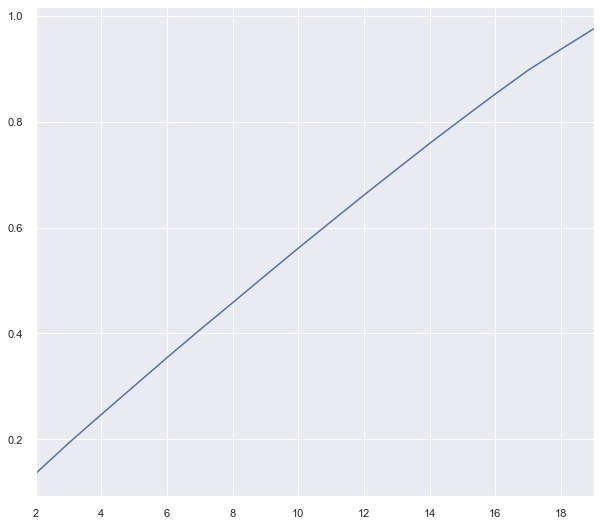

In [170]:
sns.set(rc={'figure.figsize':(10,9)})
pd.Series(var_ratio).plot()

In [171]:
var_ratio

{2: 0.13523799123553895,
 3: 0.19260680558959709,
 4: 0.24689983690528317,
 5: 0.30061929661863823,
 6: 0.3541920603848591,
 7: 0.40664343051507407,
 8: 0.4578999604913444,
 9: 0.5096961042514513,
 10: 0.5609131306292222,
 11: 0.611226861260225,
 12: 0.6612421832803812,
 13: 0.7101528564162634,
 14: 0.7587141383926935,
 15: 0.8057816275740941,
 16: 0.8520642998188759,
 17: 0.8969728489940932,
 18: 0.9366399990347486,
 19: 0.9753497917858761}

In [172]:
# 16 component is defining 85% of variability
pc_final=PCA(n_components=16).fit(analysis_scaled)
reduced_cr=pc_final.fit_transform(analysis_scaled)

In [173]:
reduced_cr.shape

(16441, 16)

In [174]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' + str(i) for i in range(16)], index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
Age_grp,0.014504,-0.503283,0.249430,0.166694,0.252771,-0.003366,-0.137287,-0.082328,-0.008446,-0.092170,-0.084651,-0.106530,0.128935,0.221105,0.259283,0.145821
Gender_grp,-0.004374,-0.209604,-0.439803,0.011453,0.294568,-0.049393,0.287085,-0.049137,-0.106545,0.095129,-0.065779,-0.168086,-0.316085,0.004314,-0.091982,0.562854
Inc_grp,-0.032724,0.608718,-0.116782,-0.016618,0.193336,-0.143504,0.035935,-0.088377,-0.107988,0.057234,0.083353,0.083451,-0.124379,-0.002634,-0.127258,0.015478
count,0.689464,0.000450,0.035981,0.024637,-0.068170,0.005572,0.042512,-0.041442,-0.045233,0.010242,-0.004972,0.078293,0.122364,-0.017685,-0.084419,-0.037712
proc_1,0.082266,0.075841,-0.016637,0.158702,0.127007,0.338889,0.305309,-0.075030,0.183908,0.242947,0.108237,0.432864,-0.332517,0.394596,0.362559,-0.142527
proc_124,-0.069633,-0.021058,0.031805,0.115311,0.114758,0.121479,0.380811,-0.073228,-0.344191,0.281258,0.463561,-0.202865,0.543013,0.010970,0.061018,-0.115918
proc_13,-0.038434,0.039313,-0.069559,0.111074,-0.002210,0.255219,0.537484,0.061773,0.127245,-0.347451,-0.535179,0.054345,0.263709,-0.028313,-0.232097,-0.163803
proc_14,0.014775,0.259821,-0.148881,0.078025,-0.022247,0.262312,-0.293908,0.305493,-0.433318,-0.185887,-0.032527,-0.239824,-0.060932,0.425163,-0.002312,-0.093815
proc_17,0.028057,-0.253364,-0.338405,-0.155411,-0.116795,0.003584,-0.198938,0.274470,0.005867,0.117612,0.151012,0.616677,0.280305,0.081362,-0.247210,0.074092
proc_19,0.073108,-0.190778,-0.180036,0.372689,-0.471832,-0.137068,0.040709,-0.359667,-0.044336,-0.147922,0.213973,-0.057617,-0.298343,-0.092528,-0.054995,-0.300013


In [175]:
pd.Series(pc_final.explained_variance_ratio_,index=['PC_' + str(i) for i in range(16)])

PC_0     0.074114
PC_1     0.062347
PC_2     0.057244
PC_3     0.055053
PC_4     0.054825
PC_5     0.052435
PC_6     0.051643
PC_7     0.051228
PC_8     0.051110
PC_9     0.050915
PC_10    0.050314
PC_11    0.050015
PC_12    0.048911
PC_13    0.048561
PC_14    0.047067
PC_15    0.046283
dtype: float64

In [179]:
# calculate Silhouette Coefficient for K=3 through K=15
k_range = range(3, 10)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(analysis_scaled)
    scores.append(metrics.silhouette_score(analysis_scaled, km.labels_))

In [181]:
scores

[0.08453699617370834,
 0.09296762645719817,
 0.11615353659781733,
 0.1662461956871548,
 0.14225507184100825,
 0.1418704098585607,
 0.16394529900585725]

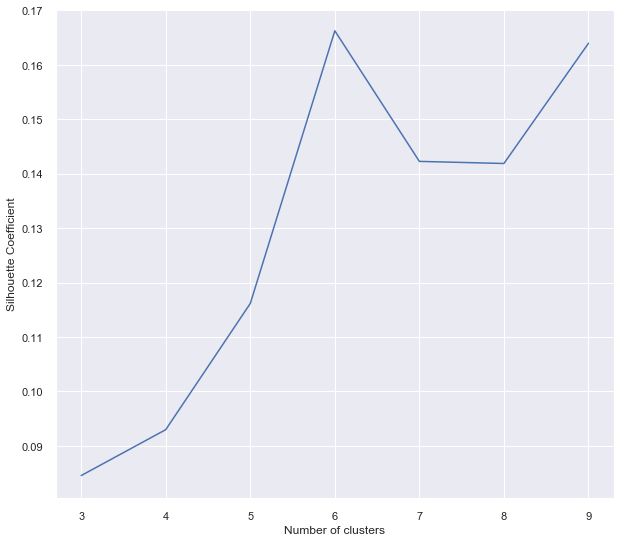

In [180]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

Silhouette Coefficient shows 6 Clusters should be taken.

In [182]:
#Elbow Analysis
cluster_range = range( 1, 15 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( analysis_scaled )
    cluster_errors.append( clusters.inertia_ )

In [183]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,1,328820.000000
1,2,310337.829731
2,3,295269.564380
3,4,278641.385067
4,5,264713.446554
5,6,250021.640677
6,7,236262.958943
7,8,224645.560508
8,9,205879.744152
9,10,190250.247643


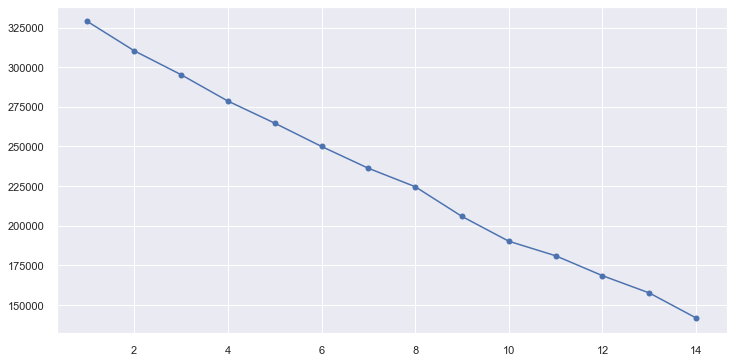

In [184]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [197]:
km_6=KMeans(init='k-means++', n_clusters=6,random_state=123)

In [198]:
km_6.fit(reduced_cr)
km_6.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [199]:
pd.Series(km_6.labels_).value_counts()

1    10917
2     4027
3      498
0      416
5      404
4      179
dtype: int64

Text(0.5, 0, 'PC_6')

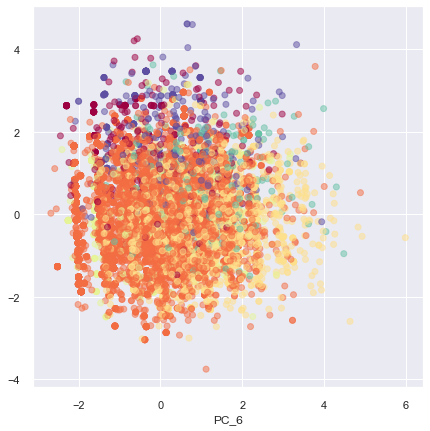

In [200]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_6.labels_,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_6')

In [201]:
km_6 = pd.DataFrame(km_6.labels_)

In [202]:
km_6.count()

0    16441
dtype: int64

In [203]:
medi_data = medi_data.reset_index()
cluster_df_6= pd.concat([medi_data, km_6], axis=1)
cluster_df_6.rename(columns={0: 'KMEANS_6'}, inplace=True)
cluster_df_6.to_csv('cluster_df_6.csv')
cluster_df_6.head()

,index,Age_grp,Gender_grp,Inc_grp,count,flag,id,proc_1,proc_10,proc_100,...,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99,KMEANS_6
0,130,2,0,3,2,0,262034,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,143,3,1,3,3,0,283176,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,185,1,0,5,2,0,355410,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,249,3,1,2,3,0,486104,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,257,2,1,4,2,0,504980,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [206]:
 cluster_final = cluster_df_6[['id', 'flag', 'KMEANS_6']]

In [207]:
cluster_final

,id,flag,KMEANS_6
0,262034,0,1
1,283176,0,1
2,355410,0,1
3,486104,0,1
4,504980,0,1
...,...,...,...
16436,998845469,1,4
16437,999347184,1,2
16438,999454987,1,1
16439,999460247,1,1


In [209]:
cluster_final.groupby('KMEANS_6')['id'].count()

KMEANS_6
0      416
1    10917
2     4027
3      498
4      179
5      404
Name: id, dtype: int64

So, Most of the anomalous patients lie in cluster 1 followed by cluster 2.